##### Κρικέλης Λάμπρος 
ΑΜ: 01852

# Project For the Subject Computetional Vision 

## Μethod for object segmentation and feature extraction 

### Generally 

There are 2 .tif files containing cells that vary in quantity and shape. 

#### Steps to fulfil the project:
Select only 10 pairs and do the below actions. 
1. You should find a way to sugment the cells
2. You should count the unique cell and extract morphological feutures

Please Complite a table with the feuteres of each cell below:

In [559]:
import cv2 
import csv
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import regionprops
from skimage import color
from skimage.segmentation import clear_border

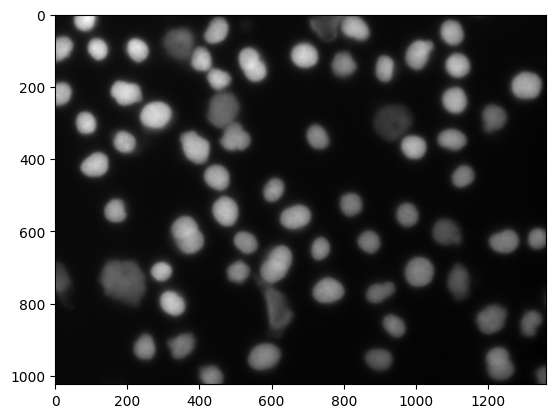

((1024, 1360), (1024, 1360, 3))

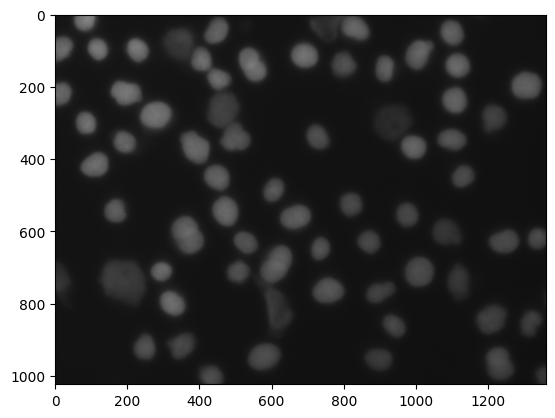

In [560]:
# Load the provided image
image_path = 'normal_40.tif'
nuclei_image = cv2.imread(image_path)
nuclei_image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(nuclei_image_gray, cmap='gray')
plt.show()
plt.imshow(nuclei_image)
nuclei_image_gray.shape ,nuclei_image.shape

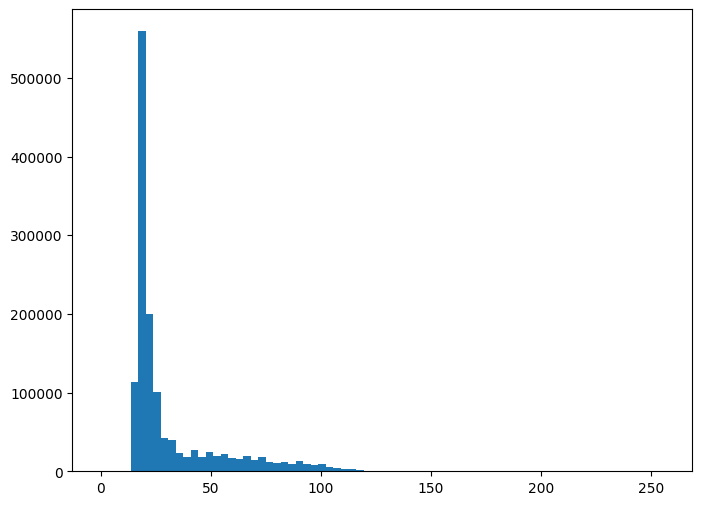

In [561]:
'''Below I am ploting the histogram With the goal of having a reference for the correct threshold below'''
plt.figure(figsize=(8, 6))
plt.hist(nuclei_image_gray.flatten(),75,[0,256])

plt.show()

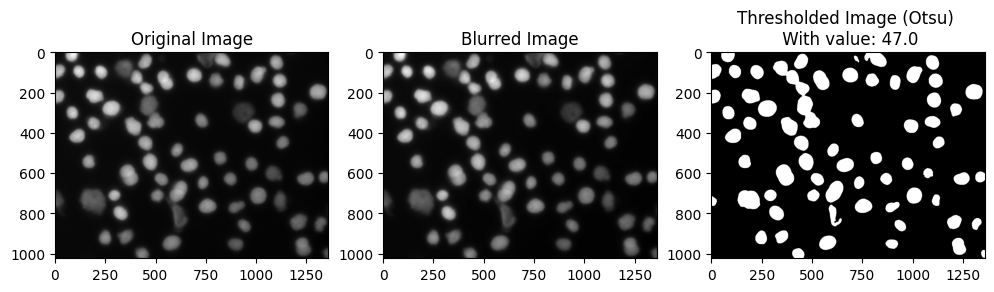

In [575]:
# Step 1:Gaussian blur to reduce noise
blurred_image = cv2.GaussianBlur(nuclei_image_gray, (7,7), 0)

# Step 2: Thresholding using Otsu's and Binary method
'''
I am using a min value from 10 with the goal of make the algorithm less bias to the 
background which is black and occupies the most space of the image. 
'''
thresh_val, thresh_image = cv2.threshold(blurred_image, 10, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# thresh_val, thresh_image = cv2.threshold(blurred_image, 10, 255, cv2.THRESH_OTSU )


# Display the results
fig, axis = plt.subplots(1, 3, figsize=(12, 6))
axis[0].imshow(nuclei_image_gray, cmap='gray')
axis[0].set_title('Original Image')

axis[1].imshow(blurred_image, cmap='gray')
axis[1].set_title('Blurred Image')

axis[2].imshow(thresh_image, cmap='gray')
axis[2].set_title(f'Thresholded Image (Otsu) \n With value: {thresh_val}')

plt.show()

Here I am trying to find the border of an abnormal rounded shape objects.--> basin
Methodology after segmatation:

1st We need the distance transform     
2nd We will implement the watershed algorithm 


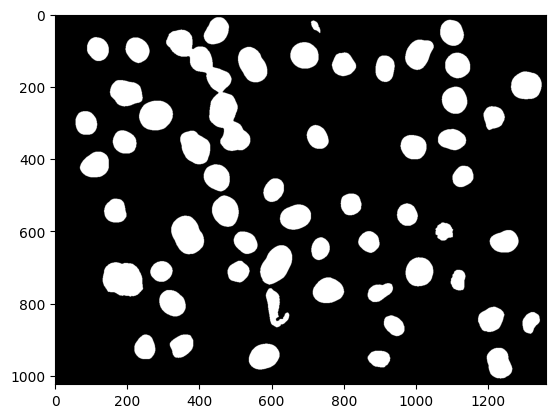

In [576]:
'''
    Here I will try to remove the noise and the cells on the boarder of the image. 
'''

kernal = np.ones((3,3),np.uint8)
# opening = cv2.morphologyEx(thresh_image,cv2.MORPH_OPEN,kernal,iterations=0)

opening = clear_border(thresh_image)
plt.imshow(opening, cmap='gray')
plt.show()


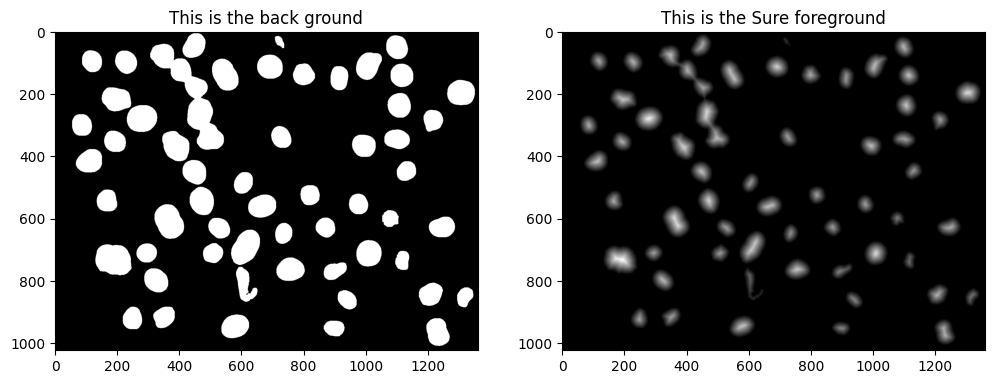

In [577]:
'''
    With this code we make sure that FOR sure we are taking only into consideration
    the foreground and the background 
    We are doing that with the aim to find the unknown area which is the area veryclose to the thresholded image
    thus the backgound - foreground = unknown. 
'''

'''with the dilate we are expanting the white area of the thresholded image.'''
sure_bg = cv2.dilate(opening,kernal,iterations=2)

'''
    I diceded to mark the foregran
'''

'''
Using the distance function,
We are calculating the minimum distance from a white pixel (cell, foreground) to a black pixel (background)."
 '''

distanceTransform = cv2.distanceTransform(opening, cv2.DIST_L2, 5).astype(np.uint8)

fig, axis = plt.subplots(1, 2, figsize=(12, 6))
axis[0].imshow(sure_bg, cmap='gray')
axis[0].set_title("This is the back ground")

axis[1].imshow(distanceTransform,cmap='gray')
axis[1].set_title("This is the Sure foreground")

plt.show()

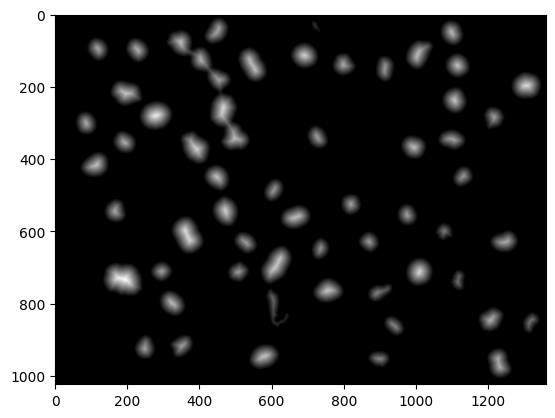

In [578]:
dist_transform_normalized = cv2.normalize(distanceTransform, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

plt.imshow(dist_transform_normalized,cmap='gray')
# plt.title(f"with the value of {distanceTransform}")
plt.show()

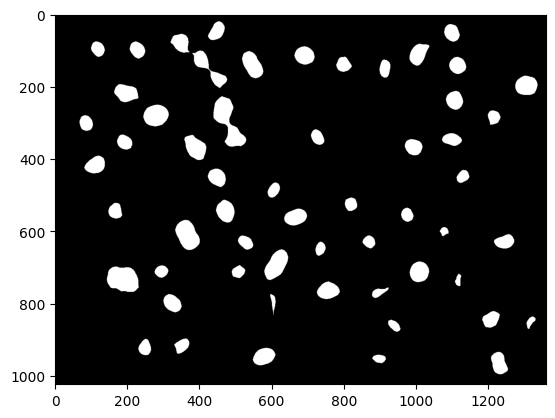

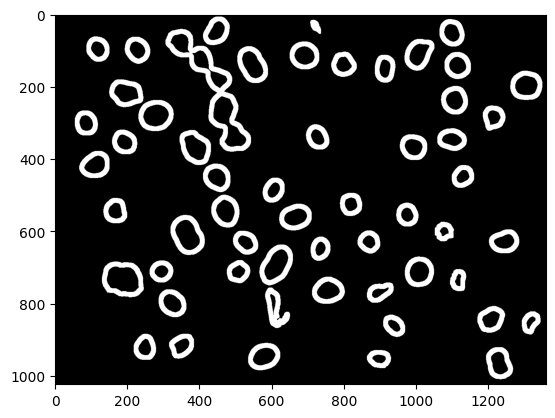

In [579]:
'''
With the code below I getting for sure the suctions that are in the cell. (sure_fg)
'''

valueoptimal, sure_fg = cv2.threshold(distanceTransform,0.25*distanceTransform.max(),255,0)
plt.imshow(sure_fg,cmap='gray')
plt.show()

unknown = cv2.subtract(sure_bg,sure_fg)
plt.imshow(unknown,cmap='gray')
plt.show()

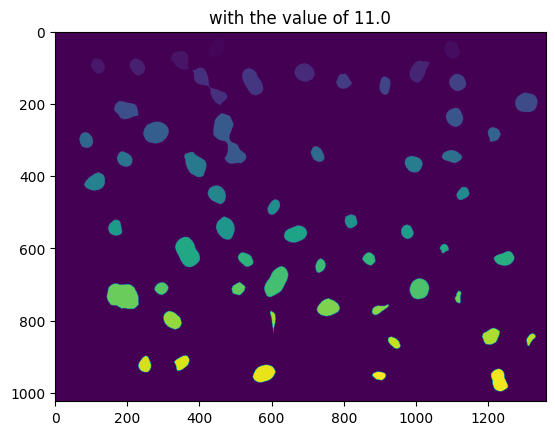

In [580]:
'''
We are using the function cv2.connectedComponents
is used to label connected regions in a binary image. 
It assigns a unique label.
'''
valuemarkers, markers = cv2.connectedComponents(sure_fg)
plt.imshow(markers)
plt.title(f"with the value of {valueoptimal}")
plt.show()

In [581]:
print(markers)
markers = markers+10
print(markers)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]


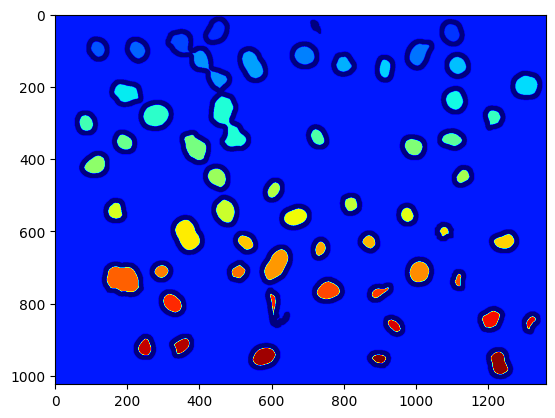

In [582]:
markers[unknown==255]=0
plt.imshow(markers,cmap='jet')
plt.show()

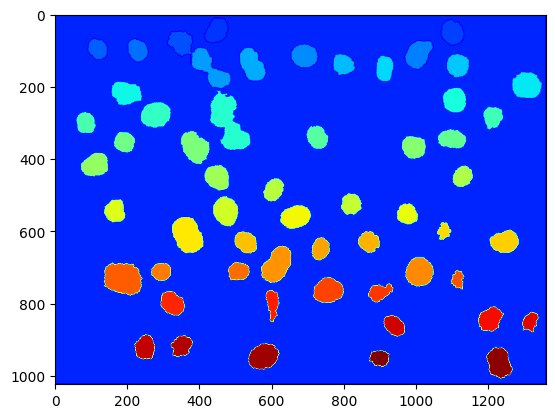

In [583]:
markers = cv2.watershed(nuclei_image,markers)
plt.imshow(markers ,cmap='jet')
plt.show()

In [584]:
'''Here  I am setting color to the borders '''
nuclei_image[markers == -1] = [255,255,0]
nuclei_image2 = color.label2rgb(markers,bg_label = 0)

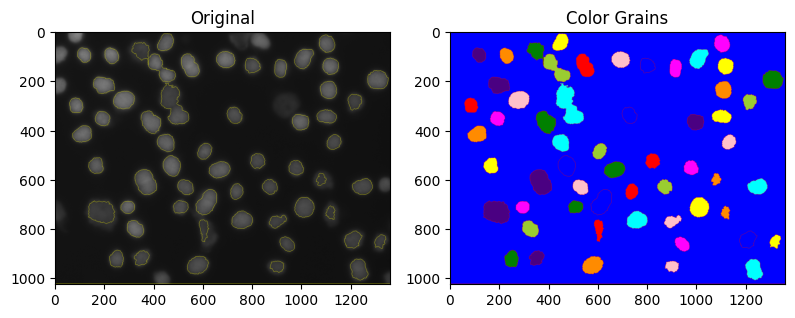

In [585]:
plt.figure(figsize=(12, 8))

# Display nuclei_image
plt.subplot(231)
plt.imshow(nuclei_image)  
plt.title('Original')

# Display nuclei_image2
plt.subplot(232)
plt.imshow(nuclei_image2) 
plt.title('Color Grains')

# plot the images together
plt.tight_layout()
plt.show()


In [586]:
'''With the function regionprops we can extract all the need information  for our cells.'''

cell_properties = regionprops(markers)

# adding label( numbers) to the cells. 
new_label_mapping = {label: idx for idx, label in enumerate(sorted(cell.label for cell in cell_properties if cell.label > 0))}

# Open a file 
with open("cell_properties_sequential.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    
    # Write the header to CSV file
    writer.writerow(["Cell ID", "Area (pixels)", "Perimeter (pixels)", 
                     "Major Axis Length (pixels)", "Minor Axis Length (pixels)", "Axis Ratio (Major/Minor)"])
    
    # We are using this list to store the informations
    cell_info = {}
    
    # Iterate through each cell region to get its properties
    for cell in cell_properties:
        # Get the original label ID for this cell
        original_label_id = cell.label
        
        # Only consider cells (exclude background and boundary)
        if original_label_id > 0:
            # Map the original label to the new sequential ID
            label_id = new_label_mapping[original_label_id]
            
            ''' 
            Below we are utilizing the ability of the regionprops function to extract the information that we need 
             
            
            Area, perimeter, major axis, and minor axis'''
            area = cell.area
            perimeter = cell.perimeter
            major_axis_length = cell.major_axis_length
            minor_axis_length = cell.minor_axis_length
            
            # Calculate the axis ratio (major/minor) if minor axis is non-zero
            if minor_axis_length > 0:
                axis_ratio = major_axis_length / minor_axis_length
            else:
                axis_ratio = float('nan')  # Handle cases where minor axis might be zero
            
            # Store results in a dictionary with the new sequential label_id as the key
            cell_info[label_id] = {
                'area': area,
                'perimeter': perimeter,
                'major_axis_length': major_axis_length,
                'minor_axis_length': minor_axis_length,
                'axis_ratio': axis_ratio
            }
            
            # Write cell properties to CSV
            writer.writerow([label_id, area, perimeter, major_axis_length, minor_axis_length, axis_ratio])
            
            # Print each cell's properties
            print(f"Cell {label_id}:")
            print(f" - Area = {area} pixels")
            print(f" - Perimeter = {perimeter} pixels")
            print(f" - Major Axis Length = {major_axis_length:.2f} pixels")
            print(f" - Minor Axis Length = {minor_axis_length:.2f} pixels")
            print(f" - Axis Ratio (Major/Minor) = {axis_ratio:.2f}")
            print("")

# Total number of cells
print(f"Total number of cells: {len(cell_info)}")


Cell 0:
 - Area = 1175638.0 pixels
 - Perimeter = 20283.40262024374 pixels
 - Major Axis Length = 1592.35 pixels
 - Minor Axis Length = 1191.66 pixels
 - Axis Ratio (Major/Minor) = 1.34

Cell 1:
 - Area = 3262.0 pixels
 - Perimeter = 242.90663761154806 pixels
 - Major Axis Length = 76.46 pixels
 - Minor Axis Length = 55.07 pixels
 - Axis Ratio (Major/Minor) = 1.39

Cell 2:
 - Area = 3318.0 pixels
 - Perimeter = 252.80613254815972 pixels
 - Major Axis Length = 70.32 pixels
 - Minor Axis Length = 60.32 pixels
 - Axis Ratio (Major/Minor) = 1.17

Cell 3:
 - Area = 3502.0 pixels
 - Perimeter = 328.71782079359116 pixels
 - Major Axis Length = 77.56 pixels
 - Minor Axis Length = 60.83 pixels
 - Axis Ratio (Major/Minor) = 1.28

Cell 4:
 - Area = 2362.0 pixels
 - Perimeter = 201.2792206135786 pixels
 - Major Axis Length = 60.25 pixels
 - Minor Axis Length = 50.21 pixels
 - Axis Ratio (Major/Minor) = 1.20

Cell 5:
 - Area = 2673.0 pixels
 - Perimeter = 218.2497833620557 pixels
 - Major Axis Leng

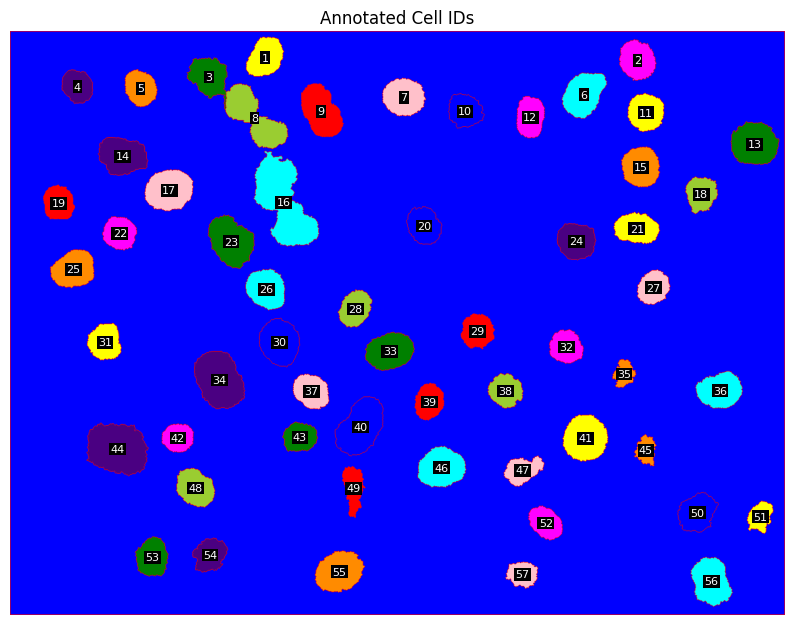

In [587]:
''' Below we are displaying the labels(the number of cells that we found )  '''

markers_sequential = markers.copy()
for original_label, new_label in new_label_mapping.items():
    markers_sequential[markers == original_label] = new_label

# Plot the image with annotated cell IDs
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(nuclei_image2)

# Annotate each cell with its sequential ID
for cell in regionprops(markers_sequential):
    # Get the cell ID and its centroid (center) coordinates
    cell_id = cell.label
    y, x = cell.centroid  # Note: centroids are in (row, col) format
    
    # Display the cell ID as text on the image
    ax.text(x, y, str(cell_id), color="white", fontsize=8, ha="center", va="center",
            bbox=dict(facecolor="black", edgecolor="none", pad=1))

# Set title and show the image
plt.title("Annotated Cell IDs")
plt.axis("off")
plt.show()